# Load data

In [66]:
import pandas as pd
from tqdm import tqdm
import os
import re
from collections import defaultdict

class train_processor():

    def __init__(self,path):
        self.path=path

    def loader(self):
        with open(self.path,'r') as train_file:
            out=[]
            for line in tqdm(train_file):
                if line.startswith('>'):
                    out.append([])
                out[-1].append(line.strip())
        out=list(map(lambda x:''.join(x),out))
        out=[out[i].split('}') for i in range(len(out))]
        
        dic_out=defaultdict(list)
        for item in out:
            tmp=re.search(r'[a-z]\.[0-9]+\.[0-9]+\.[0-9]+',item[0]).group().split('.')
            label='.'.join(tmp[:2])
            sequence=item[1]
            
            dic_out['label'].append(label)
            dic_out['sequence'].append(sequence)
        
        df=pd.DataFrame(dic_out)
        return df

class test_processor():

    def __init__(self,path):
        self.path=path
    
    def loader(self):
        test_dict=defaultdict(list)
        
        with open(self.path,'r') as test_file:
            tmp=[]
            for line in test_file:
                if line.startswith('>'):
                    tmp.append([])
                tmp[-1].append(line.strip())
            
            for item in tmp:
                test_dict['sample_id'].append(item[0][1:])
                test_dict['sequence'].append(''.join(item[1:]))

        df=pd.DataFrame(test_dict)   
        return df

In [67]:
tr_processor=train_processor(path='./data/astral_train.fa')
te_processor=test_processor(path='./data/astral_test.fa')

In [68]:
train_df=tr_processor.loader()
test_df=te_processor.loader()

43028it [00:00, 672754.74it/s]


# EDA

In [69]:
import matplotlib.pyplot as plt

### seq length

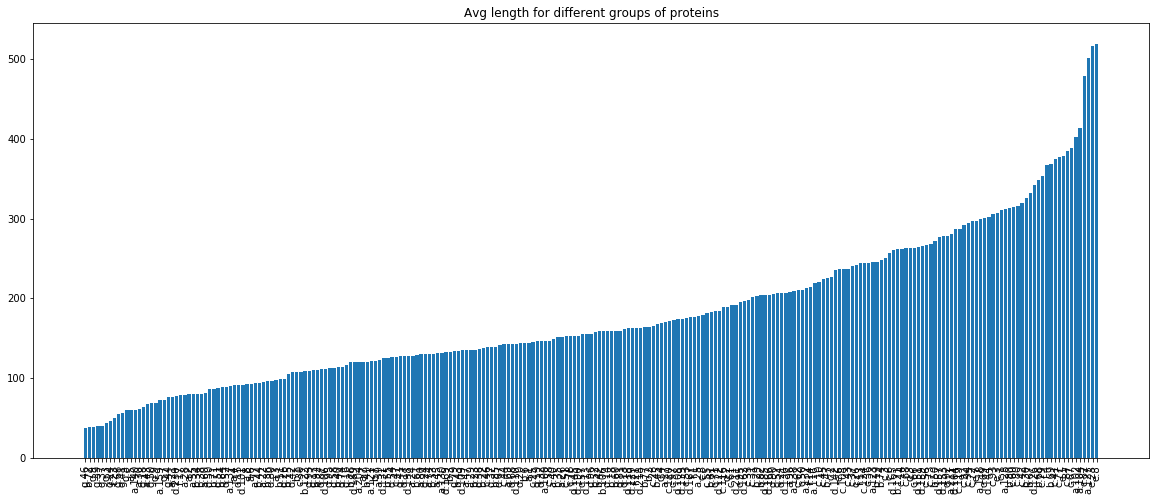

In [70]:
# explore whether the sequence length matters in classification of different groups
train_df['length']=train_df.sequence.apply(lambda x:len(x))
test_df['length']=test_df.sequence.apply(lambda x:len(x))

avg_len={}
for label in train_df.label.unique():
    sub_train_df=train_df[train_df.label==label]
    avg_len[label]=sub_train_df.length.mean()  

avg_len_sorted=sorted(avg_len.items(),key=lambda x:x[1])

labels,avglen=[i[0] for i in avg_len_sorted],[i[1] for i in avg_len_sorted]
plt.figure(figsize=(20,8))
plt.bar(labels,avglen)
plt.xticks(rotation=90)
plt.title('Avg length for different groups of proteins')
plt.show()

### proportion of each amino acid

In [71]:
train_df['tokens']=train_df.sequence.apply(lambda x:[x[i] for i in range(len(x))])
test_df['tokens']=test_df.sequence.apply(lambda x:[x[i] for i in range(len(x))])

tokens_set=set()
for i in tqdm(range(len(train_df))):
    tokens_set.update(train_df.tokens[i])

for i in tqdm(range(len(test_df))):
    tokens_set.update(test_df.tokens[i])

print(f'size of tokens:{len(tokens_set)}')

100%|██████████| 2371/2371 [00:00<00:00, 34569.68it/s]

size of tokens:23


In [72]:
# 5 groups of amino acids with different physical properties
amino_acids={1:['a','v','l','i','p','m'],
             2:['w','f'],
             3:['q','s','t','c','n','y','g'],
             4:['d','e'],
             5:['k','r','h']}

amino_acids_li=amino_acids[1]+amino_acids[2]+amino_acids[3]+amino_acids[4]+amino_acids[5]

In [73]:
# for 'X','x','z' which are quite rare, I just use dummy to represent whether they exist or not
train_df['hasX']=train_df.tokens.apply(lambda x:'X' in x).astype(int)
train_df['hasx']=train_df.tokens.apply(lambda x:'x' in x).astype(int)
train_df['hasz']=train_df.tokens.apply(lambda x:'z' in x).astype(int)

test_df['hasX']=test_df.tokens.apply(lambda x:'X' in x).astype(int)
test_df['hasx']=test_df.tokens.apply(lambda x:'x' in x).astype(int)
test_df['hasz']=test_df.tokens.apply(lambda x:'z' in x).astype(int)

In [74]:
# calculate the proportion of each group's amino acid in protein sequence
def cal_group_prop(df):
    for group_idx in range(1,6):
        df[f'group{group_idx}']=0.0
        for i in tqdm(range(df.shape[0])):
            count=0
            for token in df.tokens[i]:
                if token in amino_acids[group_idx]:
                    count+=1
            df[f'group{group_idx}'][i]=count/df.length[i]
    return df    

In [75]:
train_df=cal_group_prop(train_df)
test_df=cal_group_prop(test_df)

  0%|          | 0/9472 [00:00<?, ?it/s]/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 2371/2371 [00:00<00:00, 6449.86it/s]


In [76]:
# calulate each amino acid's proportion in the protein sequence
def cal_aa_proportion(df,start,end): 
        
    df[f'tokens{start}_{end}']=df.tokens.apply(lambda x:x[int(start*len(x)):int(end*len(x))])
    for token in sorted(amino_acids_li):
        df[f'{token}{start}_{end}']=0.0
        for i in tqdm(range(df.shape[0])):
            df[f'{token}{start}_{end}'][i]=df[f'tokens{start}_{end}'][i].count(token)/len(df[f'tokens{start}_{end}'][i])
    return df 

In [77]:
# split the sequence into 10 sub-parts
split_props=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

# for each sub-part of the sequence,calculate each amino acid's proportion
for i in range(len(split_props)-1):
    train_df=cal_aa_proportion(train_df,split_props[i],split_props[i+1])
    test_df=cal_aa_proportion(test_df,split_props[i],split_props[i+1])

  0%|          | 0/9472 [00:00<?, ?it/s]/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 9472/9472 [00:01<00:00, 7461.89it/s]


100%|██████████| 2371/2371 [00:00<00:00, 7603.60it/s]


In [78]:
# calculate the proportion of each amino acid in complete protein sequence
train_df=cal_aa_proportion(train_df,0,1)
test_df=cal_aa_proportion(test_df,0,1)

  0%|          | 0/9472 [00:00<?, ?it/s]/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 2371/2371 [00:00<00:00, 7919.20it/s]


### num of unique amino acids

In [79]:
train_df['variety']=train_df.tokens.apply(lambda x:len(set(x)))
test_df['variety']=test_df.tokens.apply(lambda x:len(set(x)))

### info of dipeptides & tripeptides

>**I also try to explore the proportion of all kinds of dipeptides and tripeptides and use them as features for modeling, But unfortunately, it is not useful !**

In [40]:
# # dipeptide (exclude X,x,z)
# dipeptides=[]
# for i in amino_acids_li:
#     for j in amino_acids_li:
#         dipeptides.append(i+j)

# train_df['tokens2']=train_df.tokens.apply(lambda x:[x[i]+x[i+1] for i in range(len(x)-1)])
# test_df['tokens2']=test_df.tokens.apply(lambda x:[x[i]+x[i+1] for i in range(len(x)-1)])

# # build dipeptide combination
# for dipeptide in dipeptides:
#     train_df[dipeptide]=0.0
#     test_df[dipeptide]=0.0

# for i in tqdm(range(train_df.shape[0])):
#     for dipeptide in dipeptides:
#         train_df[dipeptide][i]=train_df.tokens2[i].count(dipeptide)/(len(train_df.tokens2[i]))

# for i in tqdm(range(test_df.shape[0])):
#     for dipeptide in dipeptides:
#         test_df[dipeptide][i]=test_df.tokens2[i].count(dipeptide)/(len(test_df.tokens2[i]))



# # tripeptide
# tripeptides=[]
# for i in amino_acids_li:
#     for j in amino_acids_li:
#         for k in amino_acids_li:
#             tripeptides.append(i+j+k)

# for tripeptide in tripeptides:
#     train_df[tripeptide]=0.0
#     test_df[tripeptide]=0.0

# train_df['tokens3']=train_df.tokens.apply(lambda x:[x[i]+x[i+1]+x[i+2] for i in range(len(x)-2)])
# test_df['tokens3']=test_df.tokens.apply(lambda x:[x[i]+x[i+1]+x[i+2] for i in range(len(x)-2)])

# for i in tqdm(range(train_df.shape[0])):
#     for tripeptide in tripeptides:
#         train_df[tripeptide][i]=train_df.tokens3[i].count(tripeptide)/(len(train_df.tokens3[i]))

# for i in tqdm(range(test_df.shape[0])):
#     for tripeptide in tripeptides:
#         test_df[tripeptide][i]=test_df.tokens3[i].count(tripeptide)/(len(test_df.tokens3[i]))

In [83]:
train_feat=train_df.drop(['label',
                          'sequence',
                          'tokens',
                          'tokens0_0.1',
                          'tokens0.1_0.2',
                          'tokens0.2_0.3',
                          'tokens0.3_0.4',
                          'tokens0.4_0.5',
                          'tokens0.5_0.6',
                          'tokens0.6_0.7',
                          'tokens0.7_0.8',
                          'tokens0.8_0.9',
                          'tokens0.9_1',
                          'tokens0_1'],axis=1)
test_feat=test_df.drop(['sample_id',
                        'sequence',
                        'tokens',
                        'tokens0_0.1',
                        'tokens0.1_0.2',
                        'tokens0.2_0.3',
                        'tokens0.3_0.4',
                        'tokens0.4_0.5',
                        'tokens0.5_0.6',
                        'tokens0.6_0.7',
                        'tokens0.7_0.8',
                        'tokens0.8_0.9',
                        'tokens0.9_1',
                        'tokens0_1'],axis=1)

In [87]:
train_y=train_df.label

In [32]:
# svd(dim reduction)
from sklearn.decomposition import TruncatedSVD

svd=TruncatedSVD(n_components=100)
train_x=svd.fit_transform(train_feat)
test_x=svd.transform(test_feat)

In [84]:
# do the normalization
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

train_x_norm=scaler.fit_transform(train_feat)
test_x_norm=scaler.transform(test_feat)

# Model

In [86]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

In [88]:
gbdt = GradientBoostingClassifier()
svm=SVC()

# Train

In [89]:
svm.fit(train_x_norm,train_y)

SVC()

# Predict

In [90]:
prediction=svm.predict(test_x_norm)

# Submit

In [91]:
test_df['category_id']=prediction
output=test_df[['sample_id','category_id']]
output.to_csv('./tmp/submission.csv',header=True,index=False)